# Overview

This is trying out a basic task (why are these things so under-documented) - I want to store the training and eval losses, that I see on screen, to a local file so I can plot them myself (without using TensorBoard or WandB or whatever)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import set_seed
set_seed(1729) # TODO: check this does indeed do for PyTorch and NumPy etc.

2024-02-18 20:09:26.633357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 20:09:26.633469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 20:09:26.768177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f2f01b27613c0365c7720cc4b62566e79f1dc569e21f8700284bc744158ee84f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
import torch

from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric, Dataset, DatasetDict
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report

In [4]:
raw_dataset = load_dataset("conll2003")

for k in ["train","validation","test"]:
    raw_dataset[k] = raw_dataset[k].remove_columns(["pos_tags", "chunk_tags"])
    
label_list = raw_dataset["train"].features["ner_tags"].feature.names

Generating train split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3454 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
pretrained_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(pretrained_checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [7]:
tokenized_dataset = raw_dataset.map(tokenize_and_align_labels, batched=True)


print(tokenized_dataset)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3251
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3454
    })
})


In [8]:
from transformers import DataCollatorForTokenClassification
from datasets import load_metric

metric = load_metric("seqeval")

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def compute_metrics(eval_prediction_object):
    predictions, labels = eval_prediction_object
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    
    res = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    
    # ADD ENTITY LEVEL STUFF
    # YOU CAN FIND THIS IS THE results OBJECT ALSO
    for k in results.keys():
        if k not in res.keys():
            for poss_metric in results[k]:
                res[f"{k}_{poss_metric}"] = results[k][poss_metric]
    
    return res

In [14]:
id2label = {i:label for i, label in enumerate(label_list)}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(label2id.keys())

# ------- TRAINING ----------
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir=f"finetuned-{pretrained_checkpoint}-conll2003-test-no-HP-search",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=400,
    save_strategy="steps",
    save_steps=400,
    save_total_limit=1,
    logging_strategy="steps", # ADDED THIS AS EPPOCH TO SEE IF IT MAKES TRAINvEVAL LOSSES LINE UP
    logging_steps=400,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to=["tensorboard"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


trainer.train()

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Loc Precision,Loc Recall,Loc F1,Loc Number,Misc Precision,Misc Recall,Misc F1,Misc Number,Org Precision,Org Recall,Org F1,Org Number,Per Precision,Per Recall,Per F1,Per Number
400,0.230400,0.074288,0.878663,0.898182,0.888316,0.979810,0.915099,0.927055,0.921038,1837,0.726405,0.742950,0.734584,922,0.829023,0.860552,0.844493,1341,0.955804,0.974484,0.965054,1842
800,0.074800,0.058791,0.901827,0.913665,0.907708,0.982964,0.932687,0.942842,0.937737,1837,0.814270,0.779826,0.796676,922,0.821526,0.899329,0.858669,1341,0.977925,0.961998,0.969896,1842
1200,0.050400,0.051069,0.917622,0.929822,0.923681,0.985592,0.935586,0.964616,0.949879,1837,0.821739,0.819957,0.820847,922,0.885502,0.888143,0.886821,1341,0.969925,0.980456,0.975162,1842
1600,0.039300,0.050797,0.921350,0.932514,0.926899,0.986235,0.936970,0.962983,0.949799,1837,0.840834,0.830803,0.835788,922,0.882870,0.899329,0.891023,1341,0.973499,0.977199,0.975345,1842


TrainOutput(global_step=1756, training_loss=0.09353323677949318, metrics={'train_runtime': 125.7109, 'train_samples_per_second': 223.401, 'train_steps_per_second': 13.969, 'total_flos': 340555188268260.0, 'train_loss': 0.09353323677949318, 'epoch': 2.0})

In [15]:
#pd.DataFrame(trainer.state.log_history)
trainer.state.log_history

[{'loss': 0.2304,
  'learning_rate': 1.5444191343963555e-05,
  'epoch': 0.46,
  'step': 400},
 {'eval_loss': 0.07428819686174393,
  'eval_overall_precision': 0.8786631544287126,
  'eval_overall_recall': 0.8981824301581959,
  'eval_overall_f1': 0.8883155792276964,
  'eval_overall_accuracy': 0.9798099762470309,
  'eval_LOC_precision': 0.9150994089199355,
  'eval_LOC_recall': 0.9270549809471965,
  'eval_LOC_f1': 0.9210383991346673,
  'eval_LOC_number': 1837,
  'eval_MISC_precision': 0.7264050901378579,
  'eval_MISC_recall': 0.7429501084598699,
  'eval_MISC_f1': 0.7345844504021448,
  'eval_MISC_number': 922,
  'eval_ORG_precision': 0.8290229885057471,
  'eval_ORG_recall': 0.8605518269947801,
  'eval_ORG_f1': 0.8444932308818149,
  'eval_ORG_number': 1341,
  'eval_PER_precision': 0.95580404685836,
  'eval_PER_recall': 0.9744842562432139,
  'eval_PER_f1': 0.9650537634408601,
  'eval_PER_number': 1842,
  'eval_runtime': 5.4046,
  'eval_samples_per_second': 601.522,
  'eval_steps_per_second': 3

In [16]:
# list should be stable, so steps are in increasing order
train_loss_values, validation_loss_values, step_values = [], [], []

for d in trainer.state.log_history:
    if "loss" in d.keys():
        train_loss_values.append(d["loss"])
        step_values.append(d["step"])
    elif "eval_loss" in d.keys():
        validation_loss_values.append(d["eval_loss"])
        


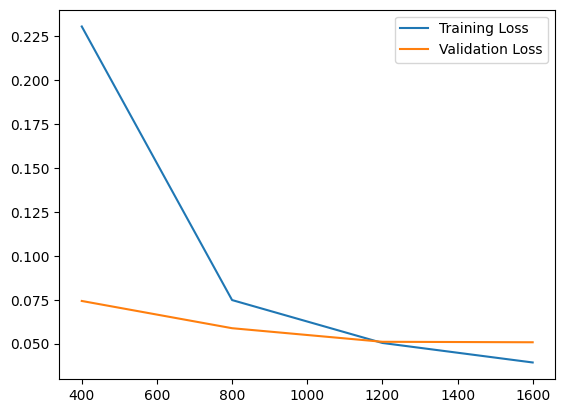

In [17]:
plt.plot(step_values, train_loss_values, label = "Training Loss") 
plt.plot(step_values, validation_loss_values, label = "Validation Loss")
plt.legend() 
plt.show()

# TODO 

Determine what the best way to report loss is, are you supposed to do by epoch or steps etc?

Is it normal for validation loss to be less than training loss at first?